In [1]:
from WaveNetContinuous import Conv
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import torchaudio

In [2]:
#Generate fake data
numTSteps = 10000
zeropad = 9
length = 10
dt = length / numTSteps
times = np.array([ dt for i in range(numTSteps)])
times = np.cumsum(times)

In [3]:
signal = np.zeros(numTSteps + zeropad)
signal[zeropad:] = np.cos(2*math.pi*times + math.pi/10) + np.cos(6*math.pi*times + math.pi/10)+ np.sin(25*math.pi*times + math.pi/10)
generated_signal = np.zeros(numTSteps + zeropad)
signal = signal / (np.max(signal) + 0.001)

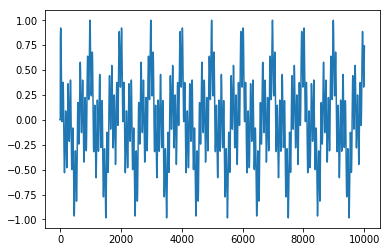

In [4]:
plt.plot(signal)

/home/josh/Desktop/CGAN/CondensedCycleGan/WaveNet2/WaveNetContinuous.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))


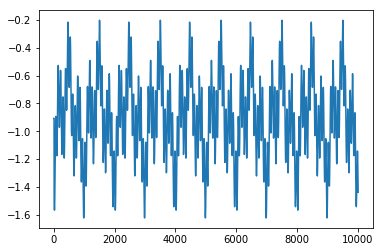

In [5]:
#Test non-causal convolution
conv = Conv(1,1)
signalt = torch.tensor(signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)
signalC = conv(signalt)
convC = signalC.squeeze(0).squeeze(0).detach().numpy()
plt.plot(convC)

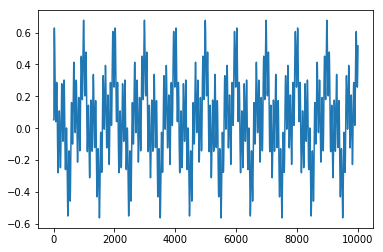

In [6]:
#Test causal convolution
conv = Conv(1,1, is_causal=True)
signalt = torch.tensor(signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)
signalC = conv(signalt)
convC = signalC.squeeze(0).squeeze(0).detach().numpy()
plt.plot(convC)

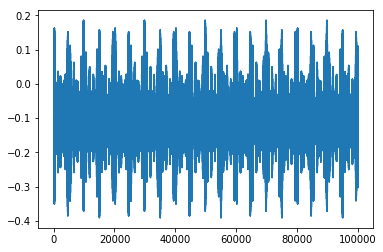

In [7]:
ConvT = torch.nn.ConvTranspose1d(1,1,10,10)
SignalCT = ConvT(signalt)
SignalCT = SignalCT.squeeze(0).squeeze(0).detach().numpy()
plt.plot(SignalCT)

In [8]:
from WaveNetContinuous import WaveNet

In [9]:
wavenet = WaveNet(n_channels = 1, n_cond_channels=1, n_layers=5,max_dilation=16,n_residual_channels=3,n_skip_channels=3, n_inputs=signalt.size(2), upsamp_window=1,upsamp_stride=1)

In [10]:
forward_input = signalt
cond_input = wavenet.upsample(signalt)
cond_input.shape

torch.Size([1, 1, 10009])

In [11]:
assert(cond_input.size(2) >= wavenet.n_inputs)
if cond_input.size(2) > forward_input.size(1):
    cond_input = cond_input[:, :, :wavenet.n_inputs]

In [12]:
forward_input = wavenet.casualInput(forward_input)
forward_input.shape

torch.Size([1, 3, 10009])

In [13]:
cond_acts = wavenet.cond_layers(cond_input)
cond_acts = cond_acts.view(cond_acts.size(0), wavenet.n_layers, -1, cond_acts.size(2))
cond_acts.shape

torch.Size([1, 5, 3, 10009])

In [14]:
in_act = wavenet.dilate_layers[0](forward_input)

In [15]:
t_act = torch.tanh(in_act[:, :wavenet.n_residual_channels, :] + cond_acts[:,1,:,:])
s_act = torch.sigmoid(in_act[:, wavenet.n_residual_channels:, :] + cond_acts[:,1,:,:])

In [16]:
t_act.shape

torch.Size([1, 3, 10009])

In [17]:
s_act.shape

torch.Size([1, 3, 10009])

In [18]:
act = t_act*s_act
act.shape

torch.Size([1, 3, 10009])

In [19]:
res_acts = wavenet.res_layers[0](act)
res_acts.shape

torch.Size([1, 3, 10009])

In [20]:
forward_input = res_acts + forward_input
forward_input.shape

torch.Size([1, 3, 10009])

In [21]:
output = wavenet.skip_layers[0](act)

In [22]:
output = torch.nn.functional.relu(output, True)
output = wavenet.conv_out(output)
output = torch.nn.functional.relu(output, True)
output = wavenet.conv_end(output)

In [23]:
output = wavenet.final_linear(output)
output = torch.tanh(output)
output

tensor([[[0.0016]]], grad_fn=<TanhBackward>)

In [24]:
wavenet

WaveNet(
  (upsample): ConvTranspose1d(1, 1, kernel_size=(1,), stride=(1,))
  (cond_layers): Conv(
    (conv): Conv1d(1, 15, kernel_size=(1,), stride=(1,))
  )
  (dilate_layers): ModuleList(
    (0): Conv(
      (conv): Conv1d(3, 6, kernel_size=(2,), stride=(1,))
    )
    (1): Conv(
      (conv): Conv1d(3, 6, kernel_size=(2,), stride=(1,), dilation=(2,))
    )
    (2): Conv(
      (conv): Conv1d(3, 6, kernel_size=(2,), stride=(1,), dilation=(4,))
    )
    (3): Conv(
      (conv): Conv1d(3, 6, kernel_size=(2,), stride=(1,), dilation=(8,))
    )
    (4): Conv(
      (conv): Conv1d(3, 6, kernel_size=(2,), stride=(1,), dilation=(16,))
    )
  )
  (res_layers): ModuleList(
    (0): Conv(
      (conv): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
    )
    (1): Conv(
      (conv): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
    )
    (2): Conv(
      (conv): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
    )
    (3): Conv(
      (conv): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
    )
  )
 

In [25]:
wavenet.forward(signalt,signalt)

tensor([[[0.0016]]], grad_fn=<TanhBackward>)

In [26]:
#Test on 2 channels.
#import torchaudio

In [27]:
#tensor, samplerate = torchaudio.load("./002012.mp3")
#tensor = tensor.unsqueeze(0)

In [28]:
tensor.size()

NameError: name 'tensor' is not defined

In [ ]:
Sample = tensor[:,:,:800]
Sample.size()

In [ ]:
wavenet = WaveNet(n_channels = 2, n_cond_channels=1, n_layers=5,max_dilation=16,n_residual_channels=3,n_skip_channels=3, n_inputs=Sample.size(2), upsamp_window=1,upsamp_stride=1)

In [ ]:
sampleCond = signalt[:,:,:800]
sampleCond.size()

In [ ]:
out = wavenet(Sample,sampleCond)

In [ ]:
out

In [ ]:
conditional1 = torch.zeros(10, 2, 15)
conditional2 = torch.rand(10, 2, 15)

In [ ]:
from WaveNetGenerator import WaveNetGenerator

In [ ]:
inputz = Sample.size(2)

In [ ]:
WaveNetDict = {"n_channels" : 2, "n_cond_channels":2, "n_layers":5,"max_dilation":16, "n_residual_channels":3,"n_skip_channels":3, "n_inputs":inputz, "upsamp_window":1,"upsamp_stride":1}

In [ ]:
WaveNetG = WaveNetGenerator(WaveNetDict,800)

In [ ]:
tensor.size()

In [ ]:
converted = WaveNetG(tensor[:,:,:10000])
converted.size()

In [ ]:
tensor[:,:,:10000].size()

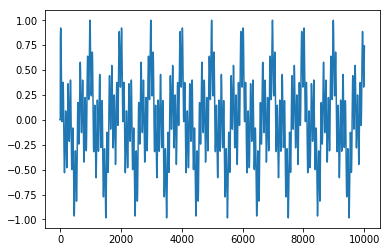

In [30]:
plt.plot(signal)

In [55]:
signalTest = torch.tensor(signal).unsqueeze(0).unsqueeze(0)

In [56]:
signalTest.shape

torch.Size([1, 1, 10009])

In [57]:
out = torch.rfft(signalTest, 2)

In [58]:
out.shape

torch.Size([1, 1, 5005, 2])

In [59]:
rnet = out.transpose(dim0=1,dim1=3).squeeze(3)
rnet.shape

torch.Size([1, 2, 5005])

In [53]:
#RezzNet

In [60]:
putback = rnet.transpose(dim0=1,dim1=2).unsqueeze(1)
putback.shape

torch.Size([1, 1, 5005, 2])

In [61]:
remake = torch.irfft(putback, 2)

In [62]:
remake.size()

torch.Size([1, 1, 10009])

In [ ]:
plt.plot(remake.squeeze(0).numpy())

In [ ]:
plt.plot(remake.squeeze(0).numpy() - signal)

In [29]:
SignalCT

array([-0.10513502, -0.10513502, -0.10513502, ...,  0.02841197,
       -0.14937899, -0.09709325], dtype=float32)